# data

In [2]:
import torch 
import importlib
import monotonic
import data_manager
import metrics
import utils
importlib.reload(utils)
import train as Train
from train import execute_model_evaluation
import train_config
from data_manager import DatasetManager
from train_config import FlatACLConfig, FlatDLinearConfig, FlatNaiveConfig, FlatPatchTSTConfig, FlatTimeMixerConfig
from dataclasses import replace

%load_ext autoreload
%autoreload 2
modules_to_reload_list = [
    data_manager,
    Train,
    train_config,
    monotonic,
    # data_manager, # Reloaded only once even if listed twice
    utils,
    # train_config, # Reloaded only once even if listed twice
    metrics
]

# Initialize the data manager
data_mgr = DatasetManager(device='cuda')

# Load a synthetic dataset
data_mgr.load_trajectory('lorenz', steps=51999, dt=1e-2) # 51999 36999
# SCALE = False

LorenzSystem initialized with method: rk4 on device: cuda

Dataset: lorenz (synthetic)
Shape: torch.Size([52000, 3])
Channels: 3
Length: 52000
Parameters: {'steps': 51999, 'dt': 0.01}

Sample data (first 2 rows):
tensor([[1.0000, 0.9800, 1.1000],
        [1.0106, 1.2389, 1.0820]], device='cuda:0')


## seq=336

### EigenACL

#### 336-96
##### huber

In [7]:
from monotonic import DynamicTanh
import torch.nn as nn

importlib.reload(monotonic)
importlib.reload(train_config) 
cfg = train_config.FlatACLConfig(  # original householder 
    seq_len=336,
    pred_len=96,
    channels=data_mgr.datasets['lorenz']['channels'],# data_mgr.channels,              # ← number of features in your data
    batch_size=128,
    learning_rate=9e-4, 
    seeds=[1955, 7, 20],  
    epochs=50, 
    dim_hidden=128,
    dim_augment=128, 
    ablate_no_koopman=False,
    use_complex_eigenvalues=True,
    second_delay_use_shift=True,
    ablate_rotate_back_Koopman=True, 
    ablate_shift_inside_scale=False,
    householder_reflects_latent = 2,
    householder_reflects_data = 4,
    mixing_strategy='delay_only',
    # single_magnitude_for_shift=True,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    ablate_deterministic_y0=False,
    

)
cfg.x_to_z_delay.enable_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_delay.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_delay.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_delay.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.x_to_z_deri.enable_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_deri.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_deri.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_deri.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.z_to_x_main.enable_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_x_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_x_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_x_main.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.z_push_to_z.enable_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_scale_shift = [True, False]
cfg.z_push_to_z.spectral_flags_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_hidden_layers = [False, False]
cfg.z_push_to_z.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_push_to_z.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.z_to_y_main.enable_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_y_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_y_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_y_main.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 282
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 96, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 96
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 282
Validation Batches: 38
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 34.7820, mae: 3.6312, huber: 3.1884, swd: 16.8735, ept: 60.0233
Epoch [1/50], Val Losses: mse: 21.7887,

In [3]:
importlib.reload(monotonic)
importlib.reload(train_config) 
cfg = train_config.FlatACLConfig(  
    seq_len=336,
    pred_len=96,
    channels=data_mgr.datasets['lorenz']['channels'],# data_mgr.channels,              # ← number of features in your data
    batch_size=128,
    learning_rate=9e-4, 
    seeds=[1955, 7, 20],  
    epochs=50, 
    dim_hidden=128,
    dim_augment=128, 
    ablate_no_koopman=False,
    use_complex_eigenvalues=True,
    second_delay_use_shift=True,
    ablate_rotate_back_Koopman=True, 
    ablate_shift_inside_scale=True,
    householder_reflects_latent = 4,
    householder_reflects_data = 8,
    mixing_strategy='delay_only',
    # single_magnitude_for_shift=True,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    ablate_deterministic_y0=False # changed

)
cfg.x_to_z_delay.enable_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_delay.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_hidden_layers = [False, False]

cfg.x_to_z_deri.enable_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_deri.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_hidden_layers = [False, False]

cfg.z_to_x_main.enable_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_x_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_hidden_layers = [False, False]

cfg.z_push_to_z.enable_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_scale_shift = [True, False]
cfg.z_push_to_z.spectral_flags_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_hidden_layers = [False, False]

cfg.z_to_y_main.enable_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_y_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_hidden_layers = [False, False]
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
Train set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 282
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 96, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 96
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 282
Validation Batches: 38
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 39.5042, mae: 3.9858, huber: 3.5350, swd: 20.9763, target_std: 13.6425
Epoch [1/50], Val Losses: mse: 20.2738, mae: 2.7349, huber: 2.2963, swd: 3.5567, target_std: 13.7293
Epoch [1/50], Test Losses: mse: 19.225

#### 336-196
##### huber

In [8]:
from monotonic import DynamicTanh
import torch.nn as nn

importlib.reload(monotonic)
importlib.reload(train_config) 
cfg = train_config.FlatACLConfig(  # original householder 
    seq_len=336,
    pred_len=196,
    channels=data_mgr.datasets['lorenz']['channels'],# data_mgr.channels,              # ← number of features in your data
    batch_size=128,
    learning_rate=9e-4, 
    seeds=[1955, 7, 20],  
    epochs=50, 
    dim_hidden=128,
    dim_augment=128, 
    ablate_no_koopman=False,
    use_complex_eigenvalues=True,
    second_delay_use_shift=True,
    ablate_rotate_back_Koopman=True, 
    ablate_shift_inside_scale=False,
    householder_reflects_latent = 2,
    householder_reflects_data = 4,
    mixing_strategy='delay_only',
    # single_magnitude_for_shift=True,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    ablate_deterministic_y0=False,
    

)
cfg.x_to_z_delay.enable_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_delay.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_delay.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_delay.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.x_to_z_deri.enable_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_deri.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_deri.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_deri.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.z_to_x_main.enable_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_x_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_x_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_x_main.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.z_push_to_z.enable_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_scale_shift = [True, False]
cfg.z_push_to_z.spectral_flags_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_hidden_layers = [False, False]
cfg.z_push_to_z.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_push_to_z.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]

cfg.z_to_y_main.enable_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_y_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_y_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_y_main.activations_hidden_layers = [nn.ELU,
                                              nn.LogSigmoid]
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 281
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 196, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 196
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 281
Validation Batches: 37
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 51.0567, mae: 4.8908, huber: 4.4279, swd: 24.4218, ept: 72.8115
Epoch [1/50], Val Losses: mse: 29.7

#### 336-336
##### huber

In [16]:
from monotonic import DynamicTanh
import torch.nn as nn

importlib.reload(monotonic)
importlib.reload(train_config) 
cfg = train_config.FlatACLConfig(  # original householder 
    seq_len=336,
    pred_len=336,
    channels=data_mgr.datasets['lorenz']['channels'],# data_mgr.channels,              # ← number of features in your data
    batch_size=128,
    learning_rate=9e-4, 
    seeds=[1955, 7, 20],  
    epochs=50, 
    dim_hidden=128,
    dim_augment=128, 
    ablate_no_koopman=False,
    use_complex_eigenvalues=True,
    second_delay_use_shift=True,
    ablate_rotate_back_Koopman=True, 
    ablate_shift_inside_scale=False,
    householder_reflects_latent = 2,
    householder_reflects_data = 4,
    mixing_strategy='delay_only', 
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    ablate_deterministic_y0=False, 
)
cfg.x_to_z_delay.enable_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_delay.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_delay.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_delay.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.x_to_z_deri.enable_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_deri.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_deri.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_deri.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.z_to_x_main.enable_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_x_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_x_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_x_main.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.z_push_to_z.enable_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_scale_shift = [True, False]
cfg.z_push_to_z.spectral_flags_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_hidden_layers = [False, False]
cfg.z_push_to_z.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_push_to_z.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.z_to_y_main.enable_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_y_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_y_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_y_main.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 280
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 336, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 336
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 280
Validation Batches: 36
Test Batches: 77

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 61.8932, mae: 5.7378, huber: 5.2647, swd: 31.0571, ept: 57.0016
Epoch [1/50], Val Losses: mse: 49.0

##### Do not use : Visualization

In [35]:
from dataclasses import fields
fields(exp.results[0])

(Field(name='cfg',type=typing.Dict,default=<dataclasses._MISSING_TYPE object at 0x000002A06B9DE840>,default_factory=<dataclasses._MISSING_TYPE object at 0x000002A06B9DE840>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='val_losses',type=typing.Dict[str, typing.Dict[str, float]],default=<dataclasses._MISSING_TYPE object at 0x000002A06B9DE840>,default_factory=<dataclasses._MISSING_TYPE object at 0x000002A06B9DE840>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='test_losses',type=typing.Dict[str, typing.Dict[str, float]],default=<dataclasses._MISSING_TYPE object at 0x000002A06B9DE840>,default_factory=<dataclasses._MISSING_TYPE object at 0x000002A06B9DE840>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='preds',type=typing.Optional[torch.Tensor],default=None,default_factory=<dataclass

In [87]:
exp.results[0].preds[-1].shape

torch.Size([1, 336, 3])

In [64]:
# 
preds = torch.stack(exp.results[0].preds[:-1], dim=0).permute(0, 1, 3, 2).reshape(-1, 336, 3)
print(preds.shape) # remove last batch
targets = torch.stack(exp.results[0].targets[:-1], dim=0).permute(0, 1, 3, 2).reshape(-1, 336, 3)
print(targets.shape) # remove last batch


torch.Size([9728, 336, 3])
torch.Size([9728, 336, 3])


In [83]:
exp.raw_test_data.shape

torch.Size([3, 10400])

In [78]:
preds.shape

torch.Size([9728, 336, 3])

In [79]:
import train as Train
importlib.reload(Train)
all_preds = Train.reconstruct_series_from_windows_torch(
    windows=preds.permute(0, 2, 1),
    stride=1,
    offset=0, #336,
)
all_targets = Train.reconstruct_series_from_windows_torch(
    windows=targets.permute(0, 2, 1),
    stride=1,
    offset=0, #336,
)
print(all_preds.shape)
print(all_targets.shape)

torch.Size([3, 10063])
torch.Size([3, 10063])


In [76]:
all_preds.shape

torch.Size([336, 9730])

In [66]:
all_targets.shape

torch.Size([336, 9730])

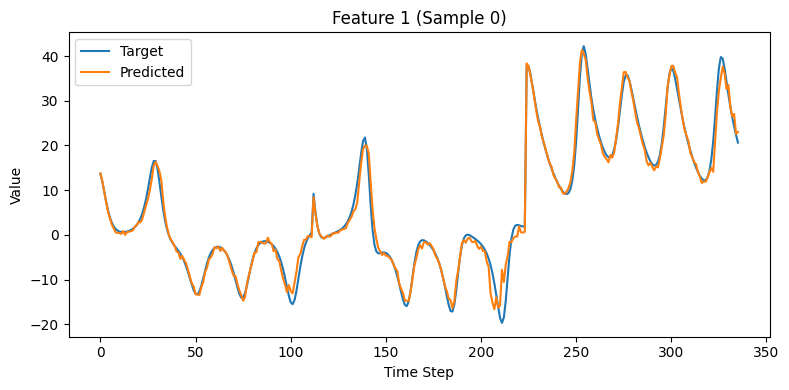

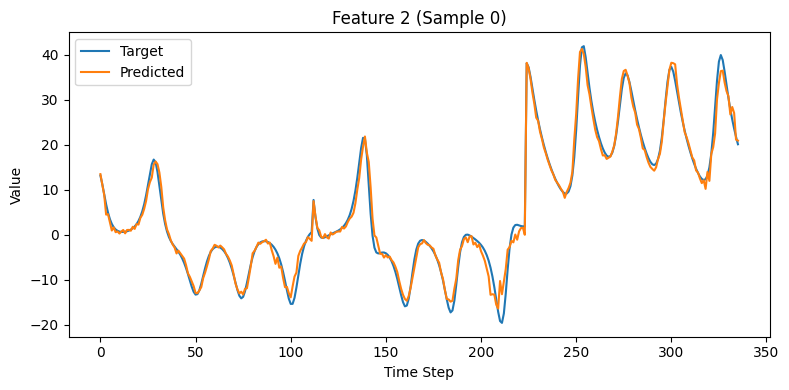

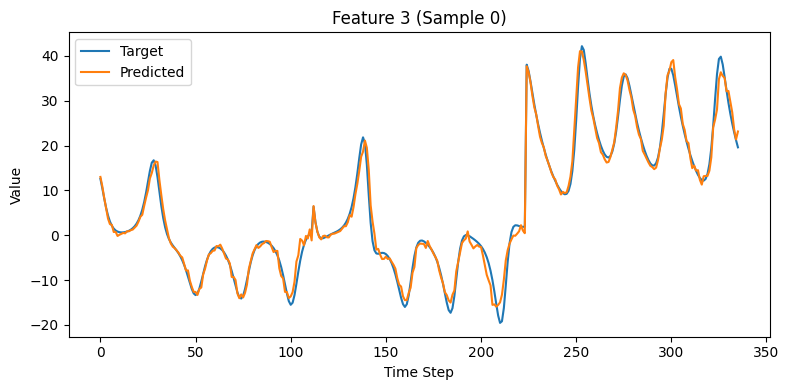

In [68]:
import matplotlib.pyplot as plt
batch_size, seq_len, features = 9728, 336, 3

# Select one sample to plot
idx = 0
time = torch.arange(seq_len)

feature_names = ['Feature 1', 'Feature 2', 'Feature 3']
for c in range(features):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(time, targets[idx, :, c], label='Target')
    ax.plot(time, preds[idx, :, c], label='Predicted')
    ax.set_title(f'{feature_names[c]} (Sample {idx})')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [75]:
targets[0,:5,:]

tensor([[13.6724, 13.1747, 12.5902],
        [11.9356, 11.2282, 10.4859],
        [ 9.7254,  8.9622,  8.2095],
        [ 7.4785,  6.7781,  6.1149],
        [ 5.4936,  4.9170,  4.3866]])

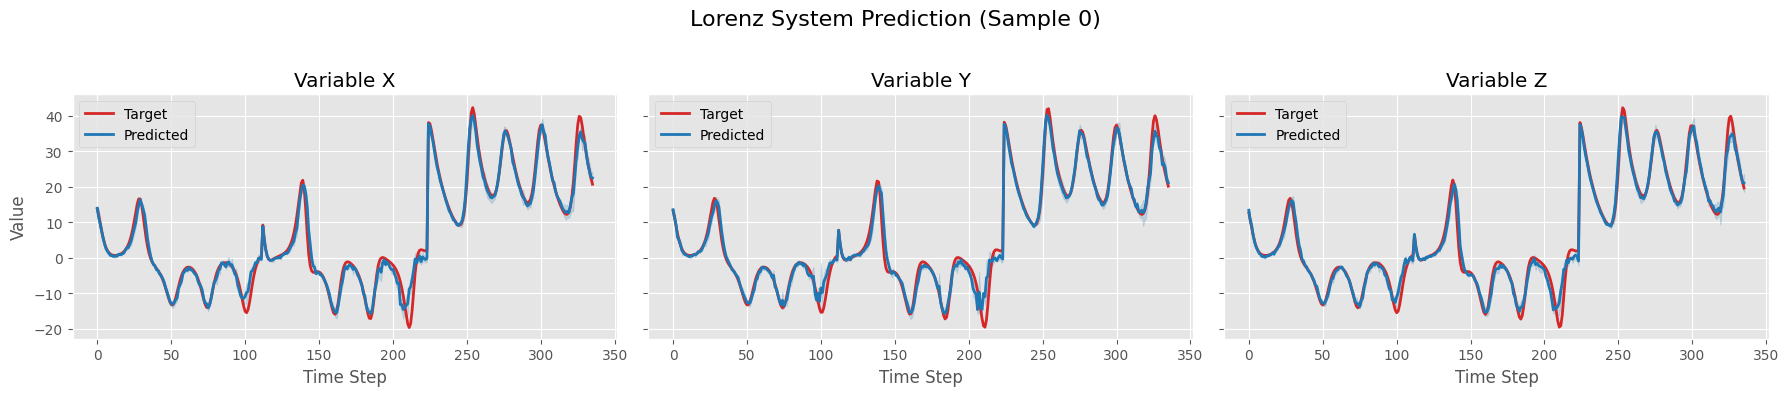

In [70]:
import matplotlib.pyplot as plt
import torch

# --- assume preds_all, targets_all defined as [3, N, 336, 3] from your 3 seeds ---
# e.g. from earlier:
# preds_all   = torch.stack([run.preds for run in exp.results[:3]], dim=0)  # shape [3,N,336,3]
# targets_all = torch.stack([run.targets for run in exp.results[:3]], dim=0)

seq_len    = preds_all.shape[2]
sample_idx = 0  # pick the first trajectory

plt.style.use('ggplot')
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
feature_names = ['x', 'y', 'z']

for i, ax in enumerate(axs):
    # compute mean & std over the 3 seeds
    pm = preds_all[:, sample_idx, :, i].mean(dim=0)
    ps = preds_all[:, sample_idx, :, i].std(dim=0)
    tm = targets_all[:, sample_idx, :, i].mean(dim=0)
    t  = torch.arange(seq_len)

    ax.plot(t, tm, label='Target',    color='tab:red',  linewidth=2)
    ax.plot(t, pm, label='Predicted', color='tab:blue', linewidth=2)
    ax.fill_between(t, pm-ps, pm+ps, color='tab:blue', alpha=0.2)

    ax.set_title(f'Variable {feature_names[i].upper()}')
    ax.set_xlabel('Time Step')
    if i == 0:
        ax.set_ylabel('Value')
    ax.legend(loc='upper left')

fig.suptitle('Lorenz System Prediction (Sample 0)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig('fig_lorenz_prediction.png', dpi=300)
plt.show()

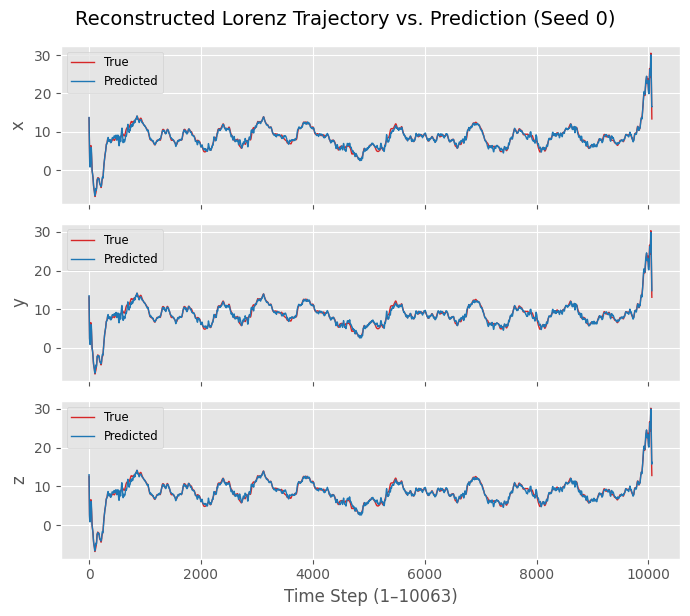

In [ ]:
import matplotlib.pyplot as plt
import torch

# all_preds, all_targets: torch.Size([3, 10063])
# Dimension 0 = Lorenz variable (x,y,z), Dimension 1 = time

pred = all_preds.numpy()
true = all_targets.numpy()

plt.style.use('ggplot')
fig, axs = plt.subplots(3, 1, figsize=(7, 6.5), sharex=True)
# fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
vars = ['x', 'y', 'z']

for i, ax in enumerate(axs):
    # ax.legend(loc='upper left', fontsize='small') 
    ax.plot(true[i],  label='True',      color='tab:red',  linewidth=1)
    ax.plot(pred[i],  label='Predicted', color='tab:blue', linewidth=1)
    ax.set_ylabel(vars[i])
    ax.legend(loc='upper left', fontsize='small')

axs[-1].set_xlabel('Time Step (1–10063)')
fig.suptitle(
    'Reconstructed Lorenz Trajectory vs. Prediction (Seed 0)', 
    fontsize=14, y=0.94
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig('fig_lorenz_full_series.png', dpi=300)
plt.show()

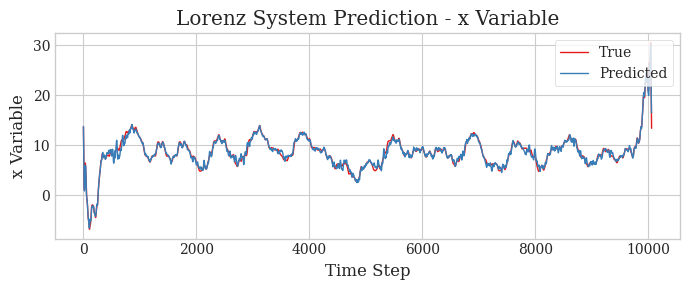

In [96]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Assuming all_preds and all_targets are already defined as before
pred_x = all_preds[0].numpy()  # Just x variable
true_x = all_targets[0].numpy()

# Set clean, professional style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'serif'

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))  # Good size for NIPS column width

# Plot the data
ax.plot(true_x, color='#E41A1C', linewidth=1, label='True')
ax.plot(pred_x, color='#377EB8', linewidth=1, label='Predicted')

# Add labels and title
ax.set_xlabel('Time Step')
ax.set_ylabel('x Variable')
ax.set_title('Lorenz System Prediction - x Variable')

# Add legend
ax.legend(loc='upper right', frameon=True)

# Tighten layout and save
plt.tight_layout()
fig.savefig('fig_lorenz_x_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

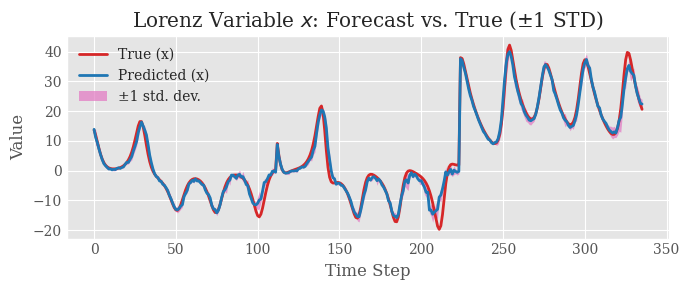

In [103]:
import matplotlib.pyplot as plt
import torch

# preds_all, targets_all: [3, N, 336, 3]
# pick sample 0, variable x => index 0
pm = preds_all[:, 0, :, 0].mean(dim=0)   # mean over 3 seeds
ps = preds_all[:, 0, :, 0].std(dim=0)    # std-dev over 3 seeds
tm = targets_all[:, 0, :, 0].mean(dim=0) # true windowed mean

t = torch.arange(pm.shape[0])

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(t, tm, label='True (x)',    color='tab:red',  linewidth=2)
ax.plot(t, pm, label='Predicted (x)', color='tab:blue', linewidth=2)
ax.fill_between(t, pm-ps, pm+ps, color='tab:pink', alpha=0.7, linewidth=0, label='±1 std. dev.')

ax.set_title('Lorenz Variable $x$: Forecast vs. True (±1 STD)')
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.legend(loc='upper left')

plt.tight_layout()
fig.savefig('lorenz_x_band.png', dpi=300)
plt.show()

#### 336-720
##### huber

In [9]:
from monotonic import DynamicTanh
import torch.nn as nn

importlib.reload(monotonic)
importlib.reload(train_config) 
cfg = train_config.FlatACLConfig(  # original householder 
    seq_len=336,
    pred_len=720,
    channels=data_mgr.datasets['lorenz']['channels'],# data_mgr.channels,              # ← number of features in your data
    batch_size=128,
    learning_rate=9e-4, 
    seeds=[1955, 7, 20],  
    epochs=50, 
    dim_hidden=128,
    dim_augment=128, 
    ablate_no_koopman=False,
    use_complex_eigenvalues=True,
    second_delay_use_shift=True,
    ablate_rotate_back_Koopman=True, 
    ablate_shift_inside_scale=False,
    householder_reflects_latent = 2,
    householder_reflects_data = 4,
    mixing_strategy='delay_only',
    # single_magnitude_for_shift=True,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    ablate_deterministic_y0=False, 
)
cfg.x_to_z_delay.enable_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_delay.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_delay.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_delay.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_delay.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.x_to_z_deri.enable_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_scale_shift = [True, False]
cfg.x_to_z_deri.spectral_flags_magnitudes = [False, True]
cfg.x_to_z_deri.spectral_flags_hidden_layers = [False, False]
cfg.x_to_z_deri.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.x_to_z_deri.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.z_to_x_main.enable_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_x_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_x_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_x_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_x_main.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.z_push_to_z.enable_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_scale_shift = [True, False]
cfg.z_push_to_z.spectral_flags_magnitudes = [False, True]
cfg.z_push_to_z.spectral_flags_hidden_layers = [False, False]
cfg.z_push_to_z.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_push_to_z.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]

cfg.z_to_y_main.enable_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_scale_shift = [True, False]
cfg.z_to_y_main.spectral_flags_magnitudes = [False, True]
cfg.z_to_y_main.spectral_flags_hidden_layers = [False, False]
cfg.z_to_y_main.activations_scale_shift = ["relu6", "dynamic_tanh"]
cfg.z_to_y_main.activations_hidden_layers = [nn.ELU, nn.LogSigmoid]
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 277
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 720, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 720
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 277
Validation Batches: 33
Test Batches: 74

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 68.8849, mae: 6.2787, huber: 5.8003, swd: 35.8427, ept: 50.3252
Epoch [1/50], Val Losses: mse: 60.3

### TimeMixer

#### 336-96
##### huber

In [4]:
utils.reload_modules([utils])
cfg = train_config.FlatTimeMixerConfig(
    seq_len=336,
    pred_len=96,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)


Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 282
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 96, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 96
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 282
Validation Batches: 38
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 45.7229, mae: 4.5079, huber: 4.0457, swd

#### 336-196
##### huber

In [3]:
utils.reload_modules([utils])
cfg = train_config.FlatTimeMixerConfig(
    seq_len=336,
    pred_len=196,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)


Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 281
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 196, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 196
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 281
Validation Batches: 37
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 54.1921, mae: 5.1094, huber: 4.6413,

#### 336-336
##### huber

In [22]:
utils.reload_modules([utils])
cfg = train_config.FlatTimeMixerConfig(
    seq_len=336,
    pred_len=336,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)


Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
Train set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 280
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 336, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 336
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 280
Validation Batches: 36
Test Batches: 77

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 62.1250, mae: 5.6608, huber: 5.1873, swd: 15.3276, target_std: 13.6390
Epoch [1/50], Val Losses: mse: 55.4265, mae: 5.2585, huber: 4.7898, swd:

#### 336-720
##### huber

In [5]:
utils.reload_modules([utils])
cfg = train_config.FlatTimeMixerConfig(
    seq_len=336,
    pred_len=720,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)


Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 277
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 720, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 720
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 277
Validation Batches: 33
Test Batches: 74

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 68.6446, mae: 6.1935, huber: 5.7156,

### PatchTST

#### 336-96
##### huber

In [6]:
utils.reload_modules([utils])
cfg_patch_tst = train_config.FlatPatchTSTConfig(
    seq_len=336,
    pred_len=96,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50,
    task_name='long_term_forecast',
    factor=3,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp_patch_tst = execute_model_evaluation('lorenz', cfg_patch_tst, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 282
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 96, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 96
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 282
Validation Batches: 38
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 44.2488, mae: 4.6542, huber: 4.1852, swd

#### 336-196
##### huber

In [7]:
utils.reload_modules([utils])
cfg_patch_tst = train_config.FlatPatchTSTConfig(
    seq_len=336,
    pred_len=196,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50,
    task_name='long_term_forecast',
    factor=3,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp_patch_tst = execute_model_evaluation('lorenz', cfg_patch_tst, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 281
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 196, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 196
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 281
Validation Batches: 37
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 57.0663, mae: 5.4904, huber: 5.0155,

#### 336-336
##### huber

In [15]:
utils.reload_modules([utils])
cfg_patch_tst = train_config.FlatPatchTSTConfig(
    seq_len=336,
    pred_len=336,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50,
    task_name='long_term_forecast',
    factor=3,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp_patch_tst = execute_model_evaluation('lorenz', cfg_patch_tst, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 280
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 336, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 336
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 280
Validation Batches: 36
Test Batches: 77

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 65.3053, mae: 6.0007, huber: 5.5227,

#### 336-720
##### huber

In [8]:
utils.reload_modules([utils])
cfg_patch_tst = train_config.FlatPatchTSTConfig(
    seq_len=336,
    pred_len=720,
    channels=data_mgr.datasets['lorenz']['channels'],
    enc_in=data_mgr.datasets['lorenz']['channels'],
    dec_in=data_mgr.datasets['lorenz']['channels'],
    c_out=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50,
    task_name='long_term_forecast',
    factor=3,
    loss_backward_weights = [0.0, 0.0, 1.0, 0.0, 0.0],
    loss_validate_weights = [0.0, 0.0, 1.0, 0.0, 0.0]
)
exp_patch_tst = execute_model_evaluation('lorenz', cfg_patch_tst, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 277
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 720, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 720
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 277
Validation Batches: 33
Test Batches: 74

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 73.6958, mae: 6.5666, huber: 6.0854,

### Dlinear

#### 336-96
##### huber

In [11]:
utils.reload_modules([utils])
cfg = train_config.FlatDLinearConfig(
    seq_len=336,
    pred_len=96,
    channels=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([96, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 282
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 96, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 96
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 282
Validation Batches: 38
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 59.9519, mae: 5.5218, huber: 5.0525, swd

#### 336-196
##### huber

In [12]:
utils.reload_modules([utils])
cfg = train_config.FlatDLinearConfig(
    seq_len=336,
    pred_len=196,
    channels=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([196, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 281
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 196, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 196
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 281
Validation Batches: 37
Test Batches: 78

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 64.8719, mae: 5.8817, huber: 5.4086,

#### 336-336
##### huber

In [13]:
utils.reload_modules([utils])
cfg = train_config.FlatDLinearConfig(
    seq_len=336,
    pred_len=336,
    channels=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([336, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 280
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 336, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 336
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 280
Validation Batches: 36
Test Batches: 77

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 66.9666, mae: 6.0744, huber: 5.5987,

#### 336-720
##### huber

In [14]:
utils.reload_modules([utils])
cfg = train_config.FlatDLinearConfig(
    seq_len=336,
    pred_len=720,
    channels=data_mgr.datasets['lorenz']['channels'],
    batch_size=128,
    learning_rate=9e-4,
    seeds=[1955, 7, 20],
    epochs=50, 
)
exp = execute_model_evaluation('lorenz', cfg, data_mgr, scale=False)

Reloading modules...
  Reloaded: utils
Module reload complete.
Shape of training data: torch.Size([36400, 3])
Shape of validation data: torch.Size([5200, 3])
Shape of testing data: torch.Size([10400, 3])
global_std.shape: torch.Size([3])
Global Std for lorenz: tensor([7.9175, 9.0168, 8.6295], device='cuda:0')
Train set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Validation set sample shapes: torch.Size([336, 3]), torch.Size([720, 3])
Test set data shapes: torch.Size([10400, 3]), torch.Size([10400, 3])
Number of batches in train_loader: 277
Batch 0: Data shape torch.Size([128, 336, 3]), Target shape torch.Size([128, 720, 3])

Data Preparation: lorenz
Sequence Length: 336
Prediction Length: 720
Batch Size: 128
Scaling: No
Train Split: 0.7
Val Split: 0.8
Training Batches: 277
Validation Batches: 33
Test Batches: 74

 Running experiment with seed 1955 (1/3)==================================================

Epoch [1/50], Train Losses: mse: 70.6884, mae: 6.3784, huber: 5.8998,